In [9]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"winnerdebofan","key":"2a7a5d85ad4bfff98ea8c49f83c960ed"}'}

In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
 ! chmod 600 ~/.kaggle/kaggle.json  

In [14]:
! kaggle datasets lits

usage: kaggle datasets
       [-h]
       {list,files,download,create,version,init,metadata,status}
       ...
kaggle datasets: error: argument command: invalid choice: 'lits' (choose from 'list', 'files', 'download', 'create', 'version', 'init', 'metadata', 'status')


In [19]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 70% 33.0M/47.0M [00:00<00:00, 80.5MB/s]
100% 47.0M/47.0M [00:00<00:00, 87.9MB/s]


In [20]:
directory = '../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset'

In [21]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflatin

In [27]:
import splitfolders

base_dir = '/content/Shoe vs Sandal vs Boot Dataset'

splitfolders.ratio(base_dir, output = './split/',
                   seed = 45, ratio = (0.7, 0.3))

train_dir = './split/train/'
val_dir = './split/val/'

Copying files: 15000 files [00:02, 6161.85 files/s]


In [32]:
labels = os.listdir('./split/train/')
labels.sort()
print(labels)

['Boot', 'Sandal', 'Shoe']


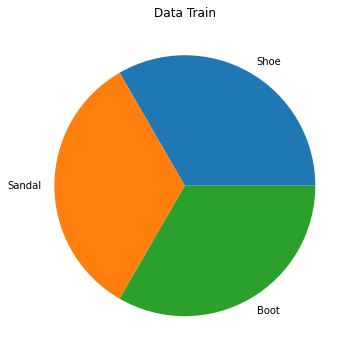

In [33]:
train_image_per_label = {'Shoe' : 0,
                         'Sandal' : 0,
                         'Boot' : 0}

for label in labels:
    train_image_per_label[label] += len(os.listdir('./split/train/' + label))
    
plt.figure(figsize = (6,6))
plt.pie(list(train_image_per_label.values()),
        labels = list(train_image_per_label.keys()))
plt.title('Data Train')
plt.show()

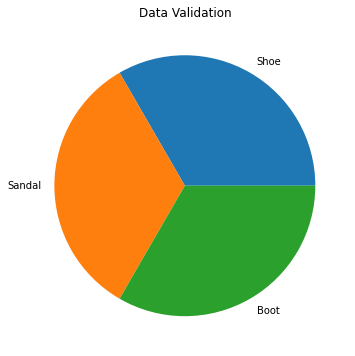

In [34]:
val_image_per_label = {'Shoe' : 0,
                       'Sandal' : 0,
                       'Boot' : 0}

for label in labels:
    val_image_per_label[label] += len(os.listdir('./split/train/' + label))
    
plt.figure(figsize = (6,6))
plt.pie(list(val_image_per_label.values()),
        labels = list(val_image_per_label.keys()))
plt.title('Data Validation')
plt.show()

In [35]:
img_height, img_width = 128, 128

train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 30,
    horizontal_flip = True,
    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
    rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = 9,
    class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    batch_size = 9,
    class_mode = 'categorical')

Found 10500 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


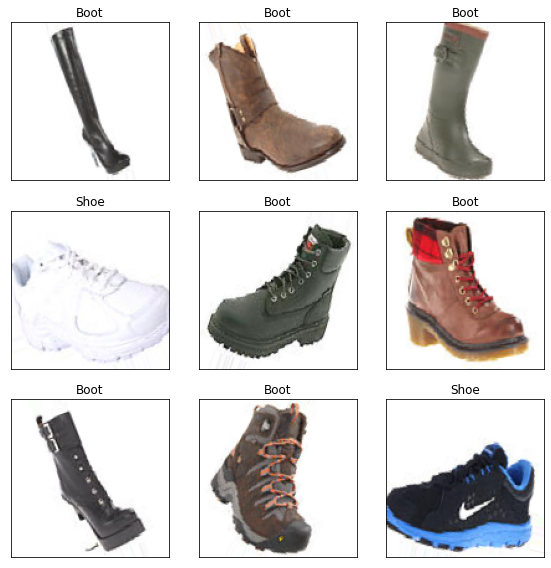

In [36]:
id_batch = 453

fig, ax = plt.subplots(3, 3, figsize = (8, 8))
for num, image in enumerate(train_generator[id_batch][0]):
    row = int(num/3)
    col = num % 3
    ax[row,col].imshow(image)
    ax[row,col].set_title(labels[np.where(train_generator[id_batch][1][num] == 1)[0][0]])
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])

fig.tight_layout()

# **CNN MODEL**

In [37]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.95:
            print("\The accuracy has reached > 0.95!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [38]:
def create_model(lr = 0.001):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(16, (3,3),
                                  activation = 'relu',
                                  input_shape = (img_height, img_width, 3)))
    model.add(keras.layers.MaxPooling2D(3,3))
    model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(4,4))
    model.add(keras.layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(3,3))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation = 'relu'))
    model.add(keras.layers.Dense(32, activation = 'relu'))
    model.add(keras.layers.Dense(3, activation = 'softmax'))
    
    adam = keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = adam,
                  metrics = ['acc'])
    
    return model

model = create_model(lr = 0.0008)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [39]:
hist = model.fit(train_generator,
                 epochs = 45,
                 steps_per_epoch = 100,
                 batch_size = 128,
                 validation_data = val_generator,
                 verbose = 1,
                 callbacks = [callbacks])

Epoch 1/45
100/100 [==============================] - 34s 329ms/step - loss: 1.0813 - acc: 0.4089 - val_loss: 0.9946 - val_acc: 0.4929
Epoch 2/45
100/100 [==============================] - 32s 322ms/step - loss: 0.8759 - acc: 0.6044 - val_loss: 0.7295 - val_acc: 0.6900
Epoch 3/45
100/100 [==============================] - 31s 313ms/step - loss: 0.7529 - acc: 0.6578 - val_loss: 0.6641 - val_acc: 0.6467
Epoch 4/45
100/100 [==============================] - 30s 303ms/step - loss: 0.6713 - acc: 0.6800 - val_loss: 0.5735 - val_acc: 0.7364
Epoch 5/45
100/100 [==============================] - 31s 308ms/step - loss: 0.6209 - acc: 0.7057 - val_loss: 0.5621 - val_acc: 0.7567
Epoch 6/45
100/100 [==============================] - 32s 319ms/step - loss: 0.5685 - acc: 0.7589 - val_loss: 0.5257 - val_acc: 0.7778
Epoch 7/45
100/100 [==============================] - 31s 312ms/step - loss: 0.5729 - acc: 0.7644 - val_loss: 0.4847 - val_acc: 0.7989
Epoch 8/45
100/100 [==============================] - 3

<function matplotlib.pyplot.show(*args, **kw)>

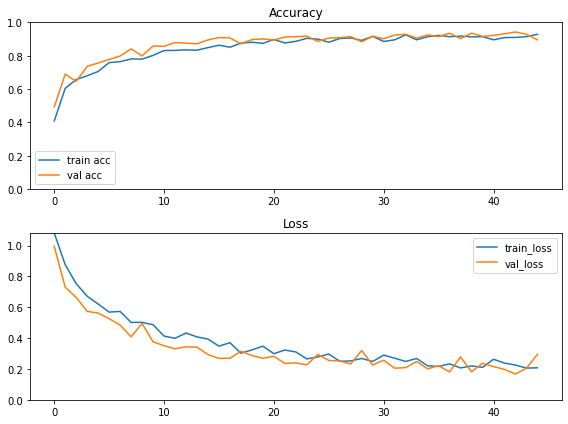

In [40]:
fig, ax = plt.subplots(2, 1, figsize = (8,6))

ax[0].plot(hist.history['acc'], label = 'train acc')
ax[0].plot(hist.history['val_acc'], label = 'val acc')
ax[0].legend()
ax[0].set_title('Accuracy')
ax[0].set_ylim(0, 1)

ax[1].plot(hist.history['loss'], label = 'train_loss')
ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].legend()
ax[1].set_title('Loss')
ax[1].set_ylim([0,max(hist.history['loss'] + hist.history['val_loss'])])

fig.tight_layout()
plt.show

1/1 [==============================] - 0s 25ms/step


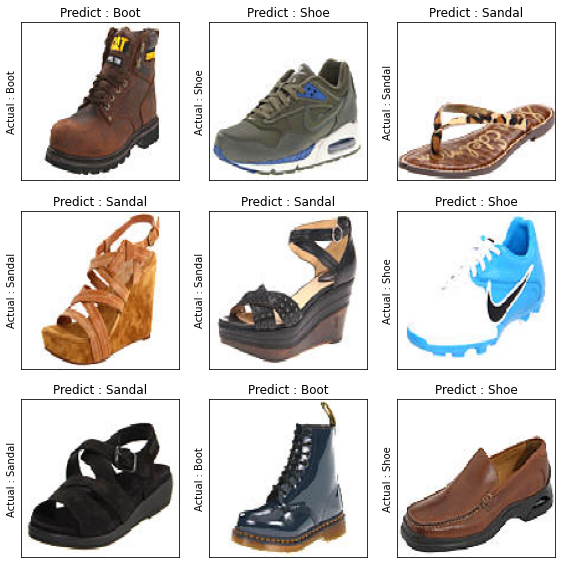

In [41]:
id_batch = 453

fig, ax = plt.subplots(3, 3, figsize = (8, 8))
for num, image in enumerate(val_generator[id_batch][0]):
    actual = 'Actual : ' + labels[np.where(val_generator[id_batch][1][num] == 1)[0][0]]
    
    image = np.expand_dims(image, axis=0)
    
    predict = model.predict(image)
    predict = 'Predict : ' + labels[np.argmax(predict)]
    
    row = int(num/3)
    col = num % 3
    ax[row,col].imshow(image[0])
    ax[row,col].set_title(predict)
    ax[row,col].set_ylabel(actual)
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])
    #ax[row,col].axis("off")

fig.tight_layout()